In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import NearestNDInterpolator, RBFInterpolator
from scipy.spatial import cKDTree as KDTree
from verde import distance_mask
import scipy
from scipy.spatial import ConvexHull
from scipy.spatial import distance_matrix
import matplotlib
import warnings
from scipy.interpolate import griddata
warnings.filterwarnings("ignore")
from scipy.interpolate import LinearNDInterpolator
from emrecharge.viz import (
    Stitched1DModel, generate_average_map
)


import fiona

import json
from pyproj import Proj, transform

# Get tTEM Data

In [2]:
import io
def read_work_bench_xyz_mod(fname):
    with open(fname, 'r') as fid:
        lines = fid.readlines()
    n_header_max = 100
    for ii, line in enumerate(lines):
        if '/' in line:
            pass
        else:
            break

    header = lines[ii-1].split()[1:]
    n_columns = len(header)
    n_sounding = len(lines[ii:])
    data = np.zeros((n_sounding, n_columns))
    for jj, line in enumerate(lines[ii:]):
        data[jj,:] = np.array(line.split(), dtype=float)
    df = pd.DataFrame(data=data, columns=header)
    tmp_thk = np.array(header)[['THK' in header for header in header]]
    thk_names = tmp_thk[:int(len(tmp_thk)/2)]
    tmp_rho = np.array(header)[['RHO' in header for header in header]]
    rho_names = tmp_rho[:int(len(tmp_thk)/2)+1]
    topo = df[['UTMX', 'UTMY', 'ELEVATION']].values[:, :]
    hz = np.unique(df[thk_names].values)
    hz = np.r_[hz, hz[-1]]
    resistivity= df[rho_names].values[:,:]
    line = df['LINE_NO'].values
    return df, topo, hz, resistivity, line

In [7]:
file_name = "Data/Inversion_FIles/SCI3_I01_MOD_inv.xyz"
df_tTEM, topo_tTEM, hz_tTEM, resistivity_tTEM, line_tTEM = read_work_bench_xyz_mod(file_name)
hz_ft= hz_tTEM * 3.28084
thickness_tTEM = hz_ft - np.append(0,hz_ft)[0:-1]


# Get AEM Data

In [8]:
em_df = pd.read_csv("Data/AEM_Data/DWR_Survey5/em_resistivity.csv")
thickness_df= pd.read_csv("Data/AEM_Data/DWR_Survey5/thickness.csv")

def read_AEM_Data_redivis(df, thickness_df):
    #transform coordinates
    output_crs = 'epsg:32611' # Coordinate system of the file
    input_crs = 'epsg:3310' # Global lat-lon coordinate system
    x, y = transform(input_crs, output_crs, df.UTMX.values, df.UTMY.values)
    df['UTMX'], df['UTMY'] = x, y
    #sort df
    lines = df.LINE_NO.unique()
    df_list = []
    for l in lines:
        df_temp = df[df.LINE_NO==l]
        df_list.append(df_temp.sort_values(['UTMX', 'UTMY'], ascending=[1, 0]))
    df = pd.concat(df_list)
    topo = df[['UTMX', 'UTMY', 'ELEVATION']].values[:, :]
    line = df['LINE_NO'].values
    hz = np.array(thickness_df.values[0][0][1:-1].split(',')).astype(float)
    hz = np.r_[hz, hz[-1]]
    res_dics = df.MEASUREMENTS.values
    n_sounding, n_layers = len(res_dics), len(hz)
    resistivity = np.zeros([n_sounding, n_layers])
    for i in range(n_sounding):
        rho = json.loads(res_dics[i])['RHO']
        resistivity[i] = rho
    return df, topo, hz, resistivity, line
    
df_SA5, topo_SA5, hz_SA5, resistivity_SA5, line_SA5 = read_AEM_Data_redivis(em_df, thickness_df)

In [82]:
print([xmin_AEM, xmax_AEM, ymin_AEM, ymax_AEM])

[254290.296875, 257898.921875, 4089789.0, 4093032.25]


# Plots

In [86]:
source_crs = 'epsg:32611' # Coordinate system of the file
target_crs = 'epsg:3310' 
x, y = df_tTEM.UTMX.values, df_tTEM.UTMY.values
dx_tTEM, dx_AEM = 50, 1100
xmin_tTEM, xmax_tTEM, ymin_tTEM, ymax_tTEM = x.min()-dx_tTEM, x.max()+dx_tTEM, y.min()-dx_tTEM, y.max()+dx_tTEM
xmin_AEM, xmax_AEM, ymin_AEM, ymax_AEM = x.min()-dx_AEM, x.max()+dx_AEM, y.min()-dx_AEM, y.max()+dx_AEM

def plot_map(i_sounding, df, extent, img):
    lines = df.LINE_NO.unique()
    df_temp = df[df.LINE_NO==lines[i_sounding]]
    X, Y= df_temp.UTMX.values, df_temp.UTMY.values
    x_all, y_all =df.UTMX.values, df.UTMY.values
    plt.imshow(img, extent = extent)
    plt.scatter(x_all, y_all, c = 'lightgrey', s = 10, label = "lines")
    plt.scatter(X, Y, c = 'blue', s = 50, label = "Shown Line")
    plt.legend(facecolor = 'grey')
    plt.scatter(X[0], Y[0], s = 150, c= 'red', marker=(5, 1))
    plt.xlabel("X (meters)")
    plt.ylabel("Y(meters)")


def plot_tTEM(i_sounding):
    extent = [xmin_tTEM, xmax_tTEM, ymin_tTEM, ymax_tTEM]
    print(extent)
    img = plt.imread('Data/ttem_br.png')
    plot_map(i_sounding, df_tTEM, extent, img)

def plot_tTEM_2d(i_layer):
    plt.figure(figsize=(7,7))
    plt.scatter(topo_tTEM[:,0], topo_tTEM[:,1], c = resistivity_tTEM[:,i_layer], cmap = 'turbo', s =5)
    plt.xlabel('UTMX (meters)')
    plt.ylabel('UTMY (meters)')
    plt.title("Layer " + str(i_layer))
    

In [87]:
n_sounding = resistivity_tTEM.shape[0]
n_layer = 25
time_stamp = df_tTEM['TIMESTAMP'].values

model = Stitched1DModel(
    # assume a flat topo?
    # this could be an option
    topography=np.c_[topo_tTEM[:,:2], np.median(topo_tTEM[:,2])*np.ones(n_sounding)],
#     topography=np.c_[topo[:,:2], np.zeros(n_sounding)],
    line=line_tTEM,
    hz=hz_tTEM[:n_layer],
    time_stamp=time_stamp, 
    physical_property=resistivity_tTEM[:,:n_layer].flatten()
)

[255340.296875, 256848.921875, 4090839.0, 4091982.25]


(<matplotlib.collections.QuadMesh at 0x15cee5220>,
 <AxesSubplot:xlabel='Distance (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x15cf16190>)

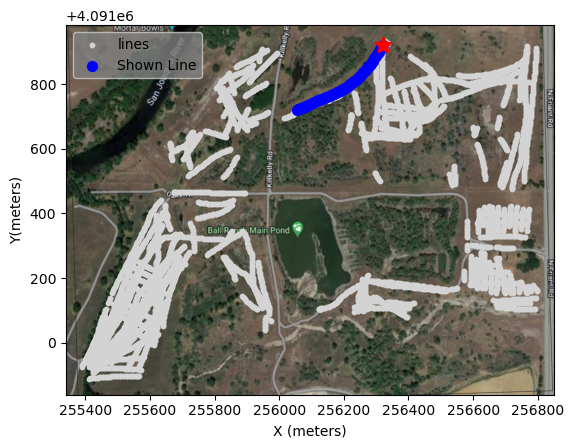

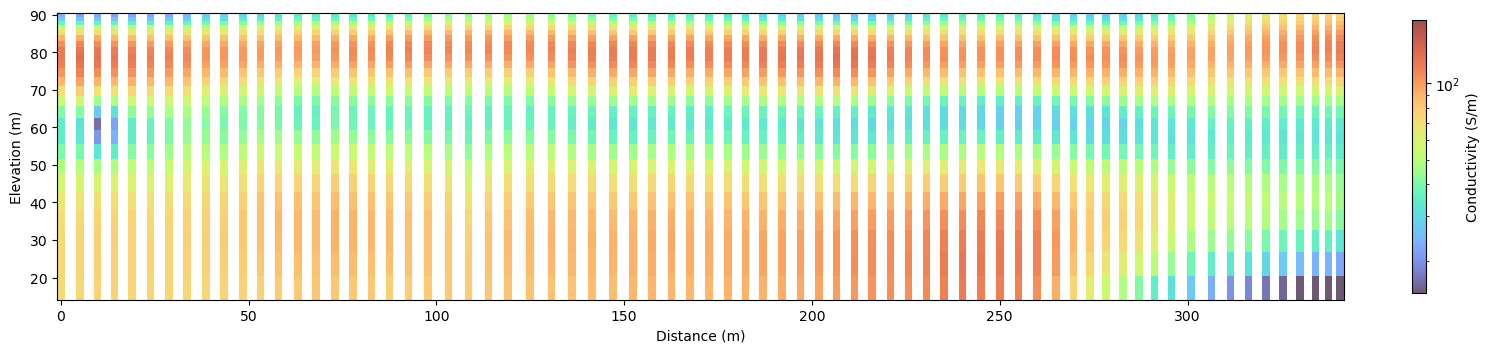

In [89]:
i_sounding = 19

plot_tTEM(i_sounding)
model.plot_section(i_line=i_sounding, x_axis='distance', dx=1, cmap='turbo')

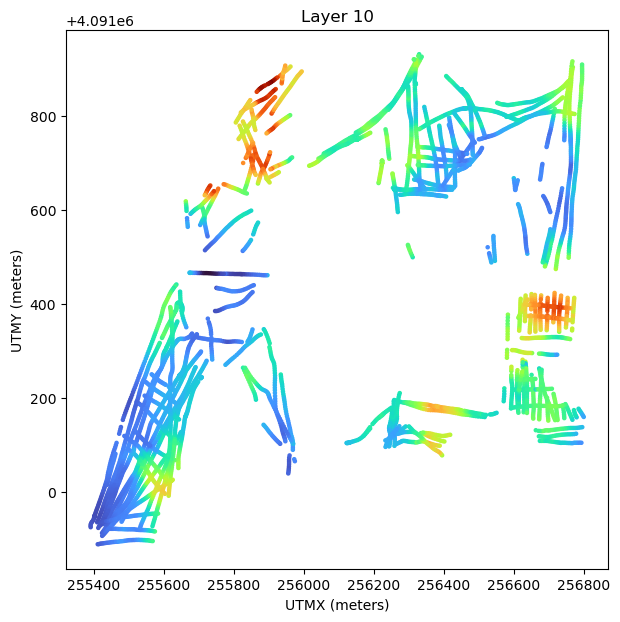

In [81]:
i_layer = 10

plot_tTEM_2d(i_layer)